# Лабораторная 10. Кластеризация

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from pandas import DataFrame
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # PCA
from sklearn.preprocessing import scale # для предобработки изображений, масштаб
from time import time

In [ ]:
df=pd.read_csv('ParisHousingClass.csv')
cols_drop = ['category','cityCode', 'numPrevOwners', 'hasYard','hasPool', 'numberOfRooms', 'squareMeters', 'attic', 'basement', 'garage', 'floors', 'isNewBuilt',	'hasStormProtector',	'hasStorageRoom']
df = df.drop(columns=cols_drop)
X=df.iloc[:,:2]
y=df.iloc[:,2]
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
print(X_sm.shape)
print(X.shape)
df_new_sm=pd.concat([X_sm, y_sm], axis=1)
df_new_sm.shape
df = df_new_sm
df.head(10)

(10068, 2)
(10000, 2)


,cityPartRange,made,hasGuestRoom
0,3,2005,7
1,8,2015,2
2,6,2021,9
3,10,2012,3
4,3,1990,4
5,8,2012,1
6,10,1995,5
7,3,2003,10
8,8,2012,5
9,5,2021,3


In [ ]:
df['Категория'] = pd.cut(df['cityPartRange'], bins=[0, 3, 6, 10], labels=[0, 1, 2]).astype(int)
df

,cityPartRange,made,hasGuestRoom,Категория
0,3,2005,7,0
1,8,2015,2,2
2,6,2021,9,1
3,10,2012,3,2
4,3,1990,4,0
...,...,...,...,...
10063,9,2009,5,2
10064,7,2009,5,2
10065,1,1994,5,0
10066,1,2000,5,0


In [ ]:
X = np.array(df.iloc[:,:3])
y = np.array(df.iloc[:,3])
X

array([[   3, 2005,    7],
       [   8, 2015,    2],
       [   6, 2021,    9],
       ...,
       [   1, 1994,    5],
       [   1, 2000,    5],
       [   3, 2001,    5]])

In [ ]:
# настройка K-Means
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 40)
# Вычислить центры кластеров и спрогнозировать индекс кластера для каждой выборки.
y_kmeans = kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X)
# центры кластеров
print(kmeans.cluster_centers_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[   5.43382353 2004.97588235    5.00029412]
 [   5.56196459 2015.99057681    5.0011422 ]
 [   5.537271   1994.41471889    4.9813645 ]]


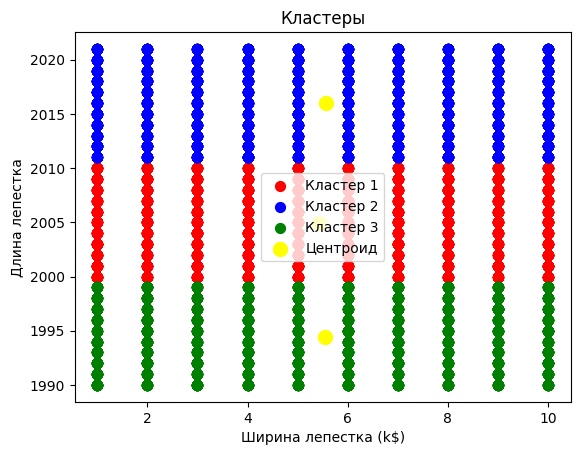

In [ ]:
# визуализация кластеров
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Кластер 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'Кластер 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'Кластер 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label =
'Центроид')
plt.title('Кластеры')
plt.xlabel('Ширина лепестка (k$)')
plt.ylabel('Длина лепестка')
plt.legend(loc='best')
plt.show()

In [ ]:
kl=kmeans.labels_.reshape(-1,1)
y_new=y.reshape(-1, 1)
z=np.hstack((X, y_new, kl))
z=DataFrame(z,columns=['cityPartRange',	'made',	'hasGuestRoom',	'Категория',
                       'claster'])
z

,cityPartRange,made,hasGuestRoom,Категория,claster
0,3,2005,7,0,0
1,8,2015,2,2,1
2,6,2021,9,1,1
3,10,2012,3,2,1
4,3,1990,4,0,2
...,...,...,...,...,...
10063,9,2009,5,2,0
10064,7,2009,5,2,0
10065,1,1994,5,0,2
10066,1,2000,5,0,0


## Расчет метрик

In [ ]:
# функция для расчета метрик
def bench_k_means(estimator, name, data):
    # принимает кластеризатор, его название, данные
    t0 = time() # старт таймера
    estimator.fit(data) # обучаем кластеризатор
    # вычисляем метрики и отображаем их
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [ ]:
data = scale(X) # предобработка, масштабируем данные, приводя к нулевому среднему и единичной дисперсии

n_samples, n_features = data.shape # число примеров и число признаков
n_digits = len(np.unique(y)) # число уникальных классов
labels = y

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

# заголовок для таблички результатов
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
# тест для k-means в котором используется улучшенный выбор начальной расстановки центроидов
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)
# тест для k-means  в котором центроиды изначально выбраны случайно из данных
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# тест для k-means  в котором начальные центроиды выбраны как главные компоненты PCA
pca = PCA(n_components=n_digits).fit(data) # вычисляем главные компоненты
bench_k_means(KMeans(init=pca.components_, # используем главные компоненты как начальные положения центроидов
                     n_clusters=n_digits, n_init=1), # здесь начальные положения центроидов не изменяются, поэтому только 1 раз делаем кластеризацию
              name="PCA-based",
              data=data)
print(82 * '_')

n_digits: 3, 	 n_samples 10068, 	 n_features 3
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.50s	17974	0.439	0.437	0.438	0.376	0.438	0.241
random   	2.43s	17946	0.317	0.315	0.316	0.266	0.316	0.259
PCA-based	0.01s	18578	0.091	0.090	0.090	0.087	0.090	0.228
__________________________________________________________________________________
